# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [ ]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold


c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

### Loading data and adding time-related features

In [ ]:
final_df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
final_df['result_timestamp'] = pd.to_datetime(final_df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')

Perform 80-20 split

In [ ]:
#split data in first 80% and last 20%
def split8020(df):
    first80 = int(len(df) * 0.8)
    last20 = int(len(df) * 0.2)
    df_first80 = df.iloc[:first80,]
    df_last20 = df.iloc[last20:,]

    return df_first80, df_last20

final_df_first80, final_df_last20 = split8020(final_df)

In [ ]:
final_df_first80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265964 entries, 0 to 265963
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   object_id         265964 non-null  int64         
 1   result_timestamp  265964 non-null  datetime64[ns]
 2   laeq              265964 non-null  float64       
 3   hour              265964 non-null  int64         
 4   day_of_week       265964 non-null  int64         
 5   month             265964 non-null  int64         
 6   weekend           265964 non-null  bool          
 7   holiday           265964 non-null  bool          
 8   exam_period       265964 non-null  bool          
 9   key               265964 non-null  object        
 10  255439            265964 non-null  bool          
 11  255440            265964 non-null  bool          
 12  255441            265964 non-null  bool          
 13  255442            265964 non-null  bool          
 14  2554

### Exploratory data analyses

Preprocessing pipeline: delaying noise and weather

In [ ]:
#Select only 3 locations close to Oude Markt
final_df_first80 = final_df_first80[final_df_first80['object_id']<255442]
final_df_last20 = final_df_last20[final_df_last20['object_id']<255442]

In [ ]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df.loc[:, ['object_id', 'result_timestamp', 'laeq']]
    df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
    df_noisedelay= df_noisedelay.drop('laeq',axis=1)
    
    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df.loc[:, ['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    #Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)
    df['key'] = df['object_id'].astype(str) + df['result_timestamp'].astype(str)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    delayed_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    delayed_df = delayed_df.dropna()

    # Create feature matrix X and target vector y
    X = delayed_df.drop(['result_timestamp', 'key','laeq', 'object_id','255442', '255443', '255444', '255445',
       '280324', '303910'], axis=1)
    y = delayed_df['laeq']

    # Return full dataframe with delays, return feature matrix X and target vector y
    return delayed_df, X, y

#Apply to df
delayed_df, X, y = delay_noise_weather(final_df_first80)
    

In [ ]:
X.info()
#y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111546 entries, 1 to 111648
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   hour          111546 non-null  int64  
 1   day_of_week   111546 non-null  int64  
 2   month         111546 non-null  int64  
 3   weekend       111546 non-null  bool   
 4   holiday       111546 non-null  bool   
 5   exam_period   111546 non-null  bool   
 6   255439        111546 non-null  bool   
 7   255440        111546 non-null  bool   
 8   255441        111546 non-null  bool   
 9   LC_TEMP_QCL1  111546 non-null  float64
 10  LC_TEMP_QCL2  111546 non-null  float64
 11  LC_TEMP_QCL3  111546 non-null  float64
 12  laeq_delayed  111546 non-null  float64
 13  LC_HUMIDITY   111546 non-null  float64
 14  LC_DWPTEMP    111546 non-null  float64
 15  LC_n          111546 non-null  float64
 16  LC_RAD        111546 non-null  float64
 17  LC_RAININ     111546 non-null  float64
 18  LC_DAILYR

Train test split

### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

Create pipeline for Ridge with spline transformations

In [ ]:
#preparing transformations and features for the Ridge regression
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    #remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#creating a standardization function for the numeric variables
scaling_features=['LC_HUMIDITY','LC_TEMP_QCL0','LC_RAD60','LC_WINDSPEED','LC_WINDDIR','LC_DAILYRAIN','LC_RAININ','LC_RAD','LC_n','LC_DWPTEMP']
standardize=ColumnTransformer(
    [
        ("standardization",StandardScaler(),scaling_features)
    ],
)

Evaluate different models and select best performing model

In [ ]:
# Create the pipelines
pipelines = [
    ('Ridge', Pipeline([
    ('features', FeatureUnion([
        ("marginal", cyclic_spline_transformer),
        ("interactions1", hour_weekend_interaction),
        ("interactions2", day_holiday_interaction),
        ("interactions3", hour_holiday_interaction),
        ('standardize', standardize)
    ])),
    ('model', Ridge())
    ])),
    ('Gradient Boosting', Pipeline([('model', HistGradientBoostingRegressor(random_state=1234))
    ])),
    ('XGBoost', Pipeline([('model', XGBRegressor(random_state=1234))
    ]))
]

In [ ]:
#create object for 5-fold cross validation with shuffled observations
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

In [ ]:
def find_best_parameters(X, y):
    # Split the data into features (X) and target (y)
    
    # Define the parameter grids for GridSearchCV
    param_grids = {
        'Ridge': {'model__alpha': np.logspace(-6, 6, 25)},

        'Gradient Boosting': {
            'model__learning_rate': [0.2,0.3,0.4],
            'model__max_leaf_nodes': [60,80]
        },

        'XGBoost': {
            'model__learning_rate': [0.10, 0.15],
            'model__n_estimators': [220,240],
            'model__max_depth': [18,19]
        }
    }
    best_pipeline = None
    best_params = None
    best_score = -float('inf')

    # Perform grid search using cross-validation for each pipeline
    for pipeline_name, pipeline in pipelines:
        param_grid = param_grids[pipeline_name]
        scorer = 'neg_mean_squared_error'
        #grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Print the best parameters and score for the current pipeline
        print(pipeline_name, "- Best Parameters: ", grid_search.best_params_)
        score = -grid_search.best_score_
        print(pipeline_name, "- Best Score: ", score)
        print("-----")

        if grid_search.best_score_ > best_score:
            best_pipeline = pipeline
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
    
    # Set the best parameters to the best pipeline
    best_pipeline.set_params(**best_params)

    # Return the best pipeline with the best parameters
    return best_pipeline
final_pipeline=find_best_parameters(X, y)

In [ ]:
final_pipeline

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=18, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=220,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [ ]:
def get_important_features(X,y,pipeline,cutoff):
#    pipeline.fit(X,y)
    explainer = shap.Explainer(pipeline.steps[-1][1])
    shap_values = explainer.shap_values(X)

    

    #summary plot
    shap.summary_plot(shap_values, X)
    #bar chart
    shap.summary_plot(shap_values, X, plot_type="bar")
    #explain a single prediction: see https://www.kaggle.com/code/dansbecker/shap-values
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
    # explain more predictions: don't really know how this works
    #shap.force_plot(explainer.expected_value, shap_values[:500,:], X.iloc[:500,:])
   

    # Calculate average absolute Shapley value for each feature
    avg_shap_values = pd.DataFrame(shap_values, columns=X.columns).abs().mean()
    sorted_features = avg_shap_values.sort_values(ascending=False)
    # Select top-k features based on the cutoff point
    selected_features = sorted_features[sorted_features >= cutoff].index.tolist()
    return X.loc[:, selected_features]
    #return(selected_features)

X_2=get_important_features(X,y,final_pipeline,0.01)


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=220, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
X_2.head()

,hour,day_of_week,holiday,255441,255440,month,255439,exam_period,LC_TEMP_QCL0,weekend,LC_RAD60,LC_TEMP_QCL3,LC_RAD,LC_HUMIDITY
0,6,5,True,True,False,1,False,False,13.28,True,0.0,11.54982,0.0,91.0
1,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52837,0.0,90.0
2,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52966,0.0,90.0
3,6,5,True,True,False,1,False,False,13.28,True,0.0,11.55408,0.0,90.0
4,6,5,True,True,False,1,False,False,13.28,True,0.0,11.72889,0.0,90.0


Once shapley works, we should implement X_2 in cells below

In [ ]:
#create test sets
delayed_df_test, X_test, y_test = delay_noise_weather(final_df_last20)

#fit best model on train and validation data
final_pipeline.fit(X, y)

#create predictions for test range
best_model_predictions = final_pipeline.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, best_model_predictions)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f"RMSE = {rmse}")



RMSE = 1.516453780710368


### Visualization of results of final model

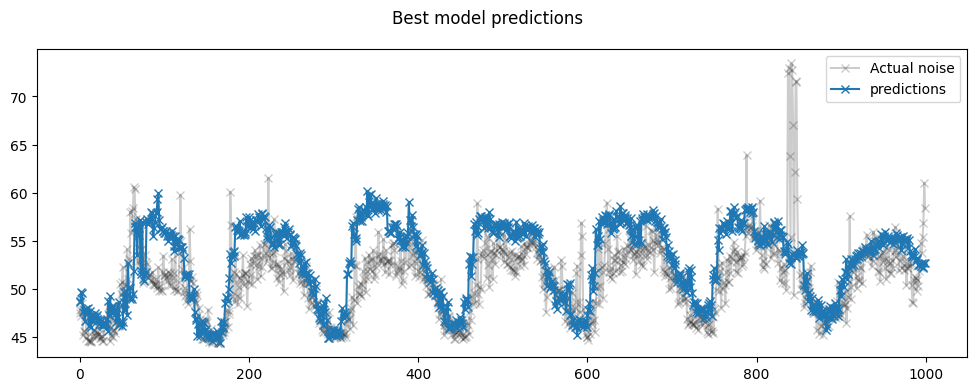

In [ ]:
#visualization of model predictions, trained on full data

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Best model predictions")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(best_model_predictions[last_hours], "x-", label="predictions")
_ = ax.legend()


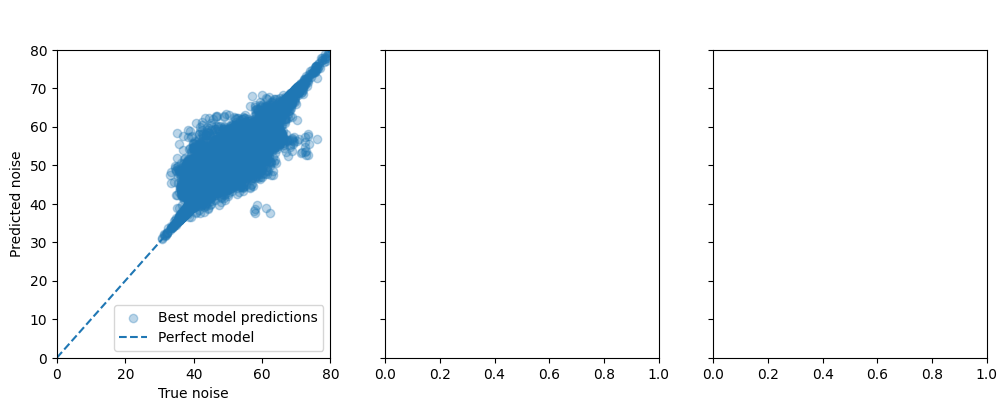

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    best_model_predictions,
]
labels = [
    "Best model predictions",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y_test.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

Shapley values

Add timestamp to predictions

In [ ]:
delayed_df_test_timestamp = pd.DataFrame(delayed_df_test['result_timestamp'])
delayed_df_test_timestamp = delayed_df_test_timestamp.reset_index()
best_model_predictions = pd.DataFrame(best_model_predictions, columns=['predictions'])
best_model_predictions = best_model_predictions.reset_index()
predictions_timestamped = pd.concat([delayed_df_test_timestamp, best_model_predictions], axis = 1)


In [ ]:
print(delayed_df_test_timestamp)

         index    result_timestamp
0            0 2022-04-06 17:40:00
1            1 2022-04-06 17:50:00
2            2 2022-04-06 17:50:00
3            3 2022-04-06 17:50:00
4            4 2022-04-06 18:00:00
...        ...                 ...
106536  106687 2022-12-31 23:10:00
106537  106688 2022-12-31 23:20:00
106538  106689 2022-12-31 23:30:00
106539  106690 2022-12-31 23:40:00
106540  106691 2022-12-31 23:50:00

[106541 rows x 2 columns]


In [ ]:
print(len(best_model_predictions))
print(len(delayed_df_test['result_timestamp']))
print(len(predictions_timestamped['result_timestamp']))

106541
106541
106541


In [ ]:
predictions_timestamped.isna().sum()

index               0
result_timestamp    0
index               0
predictions         0
dtype: int64

In [ ]:
predictions_timestamped

,index,result_timestamp,index,predictions
0,0,2022-04-06 17:40:00,0,55.896908
1,1,2022-04-06 17:50:00,1,53.736359
2,2,2022-04-06 17:50:00,2,54.909611
3,3,2022-04-06 17:50:00,3,56.083450
4,4,2022-04-06 18:00:00,4,54.668110
...,...,...,...,...
106536,106687,2022-12-31 23:10:00,106536,52.664200
106537,106688,2022-12-31 23:20:00,106537,52.645420
106538,106689,2022-12-31 23:30:00,106538,52.766701
106539,106690,2022-12-31 23:40:00,106539,52.480705


In [ ]:
predictions_timestamped = predictions_timestamped.drop('index',axis=1)

In [ ]:
predictions_timestamped

,result_timestamp,predictions
0,2022-04-06 17:40:00,55.896908
1,2022-04-06 17:50:00,53.736359
2,2022-04-06 17:50:00,54.909611
3,2022-04-06 17:50:00,56.083450
4,2022-04-06 18:00:00,54.668110
...,...,...
106536,2022-12-31 23:10:00,52.664200
106537,2022-12-31 23:20:00,52.645420
106538,2022-12-31 23:30:00,52.766701
106539,2022-12-31 23:40:00,52.480705


In [ ]:
predictions_timestamped.to_csv('predictions_timestamped.csv', index=False)

Shapley values